In [1]:
import numpy as np
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import itertools
import random
from tqdm.notebook import tqdm_notebook
from tqdm.contrib.itertools import product

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import colors
import matplotlib.patches as patches
import seaborn as sns

plt.rcParams['text.usetex'] = True

import warnings
warnings.filterwarnings('ignore')

In [2]:
class GassuianMixtureDistribuiton:

    def __init__(self, pos_prob, pos_mu, pos_std, neg_mu, neg_std):
        self.pos_prob = pos_prob
        self.pos_mu = pos_mu
        self.pos_std = pos_std
        self.neg_mu = neg_mu
        self.neg_std = neg_std

    def sample(self, n):
        y = np.random.binomial(1, self.pos_prob, n)
        x = (y == 1) * np.random.normal(self.pos_mu, self.pos_std, n) + (y == 0) * np.random.normal(self.neg_mu, self.neg_std, n)
        return x, y

    def sample_conditioned_on_y(self, n, y):
        x = (y == 1) * np.random.normal(self.pos_mu, self.pos_std, n) + (y == 0) * np.random.normal(self.neg_mu, self.neg_std, n)
        return x

In [3]:
from sklearn.linear_model import LogisticRegression

class LinearClassifier:

    def __init__(self, enc_z, b=0.5, penalty=None, C=1):
        self.enc_z = enc_z
        self.cls = LogisticRegression(penalty=penalty, solver="saga", C=C)
        self.b = b

    def prepare_data(self, Z, X):
        Z_onehot = self.enc_z.transform(Z.reshape(-1, 1)).toarray()
        if len(X.shape) == 1:
           X = X.reshape(-1, 1)
        input = np.concatenate((Z_onehot, X), axis=1)
        input_df = pd.DataFrame(input, columns = [f"z_{z}" for z in Z_values] + [f"x_{i}" for i in range(X.shape[1])])
        return input_df


    def fit(self, Z, X, Y):
        train_input = self.prepare_data(Z, X)
        self.cls.fit(train_input, Y)


    def __call__(self, Z, X):
        if len(Z) == 0:
            return np.array([])
        input = self.prepare_data(Z, X)
        probs = self.cls.predict_proba(input)
        return (probs[:, 1] > self.b).astype(int)

    def set_b(self, b):
        self.b = b

def get_classificaiton_statistics(Z, X, Y, cls):
    Yhat = cls(Z, X)
    dfs = []
    for z, y, yhat in itertools.product(Z_vals, [0, 1], [0, 1]):
        dfs.append(pd.DataFrame({
            "z": [z],
            "y": y,
            "yhat": yhat,
            "count": ((Z == z) & (Y == y) & (Yhat == yhat)).sum()
        }))
    stats = pd.concat(dfs)
    return stats

In [4]:
eps = 0.001

def precision(stats):
    if stats["count"].sum() == 0:
        return -1
    enum = stats[(stats.yhat == 1) & (stats.y == 1)]["count"].sum()
    denom = stats[stats.yhat == 1]["count"].sum() + eps
    return enum / denom


def accuracy(stats):
    if stats["count"].sum() == 0:
        return -1
    return stats[stats.yhat == stats.y]["count"].sum() / stats["count"].sum()


def will_apply(z, stats, c_u):
    return float(precision(stats[stats.z == z]) > c_u)


def get_applicaiton_decision_for_X(Z, stats, c_u):
    A = np.zeros(len(Z))
    for z in Z_vals:
        A[Z == z] = will_apply(z, stats, c_u)
    return A


def get_induced_distribution(Z, X, Y, stats, c_u):
    Z_f_list, X_f_list, Y_f_list = [], [], []
    for z in np.unique(Z):
        if will_apply(z, stats, c_u):
            idx = np.where(Z == z)
            Z_f_list.append(Z[idx])
            X_f_list.append(X[idx])
            Y_f_list.append(Y[idx])
    if len(Z_f_list) == 0:
        Z_f_list, X_f_list, Y_f_list = [np.array([])], [np.array([])], [np.array([])]
    return np.concatenate(Z_f_list), np.concatenate(X_f_list), np.concatenate(Y_f_list)


def system_utility(A, Yhat, Y):
    return (A * Yhat * (Y - c_s)).mean()

def system_utility_on_participating_users(A, Yhat, Y):
    return (Yhat * (Y - c_s))[A == 1].mean()

In [6]:
def changing_threshold_exp(cls, Z, X, Y, c_u, n=100):

    dfs = []
    b_values = np.linspace(0, 0.99, n)
    for b in tqdm_notebook(b_values):
        cls.set_b(b)
        Yhat = cls(Z, X)
        stats = get_classificaiton_statistics(Z, X, Y, cls)
        A = get_applicaiton_decision_for_X(Z, stats, c_u)
        applications = [will_apply(x, stats, c_u) for x in Z_vals]
        Z_f, X_f, Y_f = get_induced_distribution(Z, X, Y, stats, c_u)
        Yhat_f = cls(Z_f, X_f)
        induced_stats = get_classificaiton_statistics(Z_f, X_f, Y_f, cls)

        data = {
                "acc": [accuracy(stats)],
                "prec": precision(stats),
                "induced_acc": accuracy(induced_stats),
                "induced_prec": precision(induced_stats),
                "mean_y_f": Y_f.mean(),
                "induced_util_s": system_utility(A, Yhat, Y),
                "induced_util_s_on_participating_users": system_utility_on_participating_users(A, Yhat, Y),
                "mean_apply": A.mean(),
                "mean_pass_screening": (A * Yhat).mean(),
                "b": b
            }
        for i in Z_vals:
            data[f"z{i}_apply"] = will_apply(i, stats, c_u)
            data[f"z{i}_prec"] = precision(stats[stats.z == i])
            data[f"z{i}_acc"] = accuracy(stats[stats.z == i])
        dfs.append(
            pd.DataFrame(data))
    results = pd.concat(dfs)
    return results

## prep data

Z0:


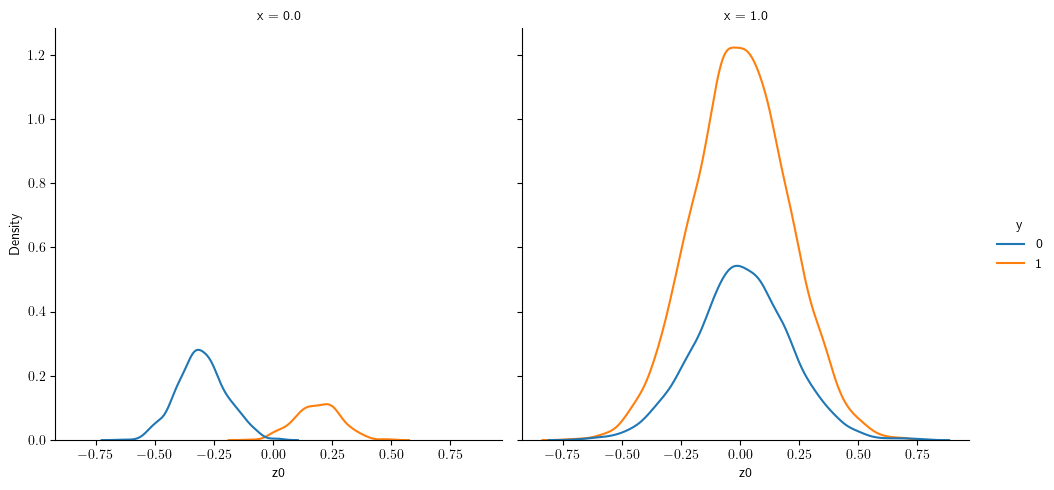

Z1:


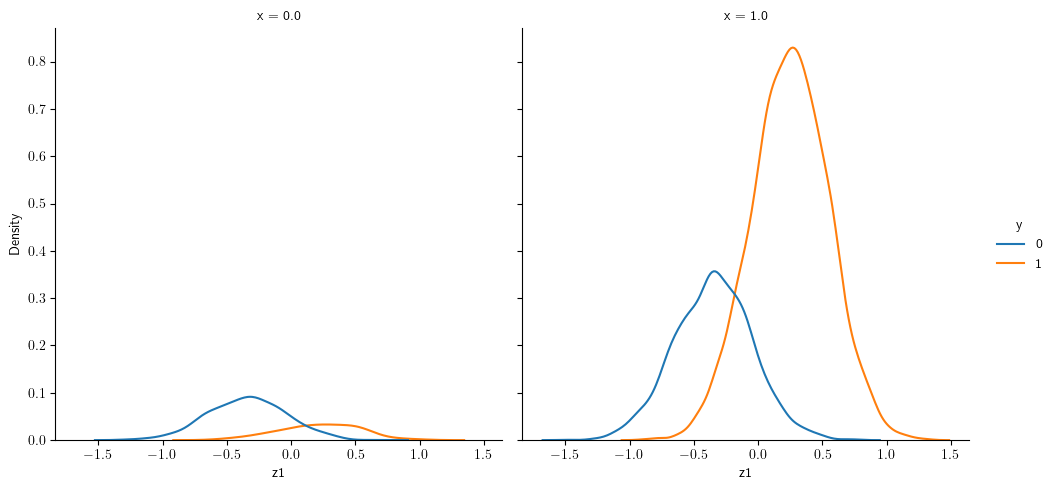

In [38]:
dists = []

d = 0.5

# z0
# x0
pos_prob = 0.3 #0.5
pos_mu = 0.7-d
pos_std = 0.1
neg_mu = 0.2-d
neg_std = 0.1
z0_x0_dist = GassuianMixtureDistribuiton(pos_prob, pos_mu, pos_std, neg_mu, neg_std)
dists.append(z0_x0_dist)
# x1
pos_prob = 0.3 #0.5
pos_mu = 0.75-d
pos_std = 0.3
neg_mu = 0.15-d
neg_std = 0.3
z0_x1_dist = GassuianMixtureDistribuiton(pos_prob, pos_mu, pos_std, neg_mu, neg_std)
dists.append(z0_x1_dist)

# z1
# x0
pos_prob = 0.7 #0.5
pos_mu = 0.5-d
pos_std = 0.2 #0.1
neg_mu = 0.5-d
neg_std = 0.2 #0.1
z1_x0_dist = GassuianMixtureDistribuiton(pos_prob, pos_mu, pos_std, neg_mu, neg_std)
dists.append(z1_x0_dist)
# x1
pos_prob = 0.7 #0.5
pos_mu = 0.75-d
pos_std = 0.3
neg_mu = 0.15-d
neg_std = 0.3
z1_x1_dist = GassuianMixtureDistribuiton(pos_prob, pos_mu, pos_std, neg_mu, neg_std)
dists.append(z1_x1_dist)


z_1_prob = 0.9
n_samples = 10000
z0_n_samples = int(n_samples * (1 - z_1_prob))
z1_n_samples = n_samples - z0_n_samples

z0_x0, z0_y = z0_x0_dist.sample(z0_n_samples)
z0_x1 = z0_x1_dist.sample_conditioned_on_y(z0_n_samples, z0_y)
z1_x0, z1_y = z1_x0_dist.sample(z1_n_samples)
z1_x1 = z1_x1_dist.sample_conditioned_on_y(z1_n_samples, z1_y)

Z_vals = [0, 1]
X = np.concatenate([np.zeros(z0_n_samples), np.ones(z1_n_samples)])
X0 = np.concatenate([z0_x0, z1_x0])
X1 = np.concatenate([z0_x1, z1_x1])
Z = np.concatenate((X0.reshape(-1, 1), X1.reshape(-1, 1)), axis=1)
Y = np.concatenate([z0_y, z1_y])
Z_values = np.unique(X)

data = pd.DataFrame({"z": X, "x0": X0, "x1": X1, "y": Y})
print("X0:")
sns.displot(data, x="x0", hue="y", col="z", kind="kde")
plt.show()
print("X1:")
sns.displot(data, x="x1", hue="y", col="z", kind="kde")
plt.show()

In [39]:
c_u = 0.8
c_s = 0.8

## run

In [ ]:
def train(Z, X, Y, c_u, n=100):
    enc_z = OneHotEncoder(handle_unknown='ignore')
    enc_z.fit(Z.reshape(-1, 1))

    naive_cls = LinearClassifier(enc_z)
    naive_cls.fit(Z, X, Y)

    Yhat = naive_cls(Z, X)
    stats = get_classificaiton_statistics(Z, X, Y, naive_cls)
#     A = get_applicaiton_decision_for_X(X, stats)
    apps = [will_apply(z, stats, c_u) for z in Z_vals]
    Z_f, X_f, Y_f = get_induced_distribution(Z, X, Y, stats, c_u)
    Yhat_f = naive_cls(Z_f, X_f)
    induced_stats = get_classificaiton_statistics(Z_f, X_f, Y_f, naive_cls)

    naive_cls_acc = accuracy(stats)
    naive_cls_induced_acc = accuracy(induced_stats)
    accs = [naive_cls_acc, naive_cls_induced_acc]
    print(f"Naive classifier results:\n\tApplicaitons: a_0={apps[0]}, \
    a_1={apps[1]}\n\tAcc: {naive_cls_acc}\n\tInduced Acc: {naive_cls_induced_acc}")

    coef = naive_cls.cls.coef_[0].copy()
    intrcpt = naive_cls.cls.intercept_.copy()
    print(coef, intrcpt)
    coef[:-1] += intrcpt
    coef /= coef[-1]
    
    naive_res = changing_threshold_exp(naive_cls, Z, X, Y, c_u, n)
    return naive_res, accs, apps, coef

In [41]:
n = 100

naive_res, naive_accs, naive_apps, naive_coef = train(Z, X, Y, c_u, n)
opt_res, opt_accs, opt_apps, opt_coef = train(Z, X0, Y, c_u, n)

Naive classifier results:
	Applicaitons: a_0=1.0,     a_1=1.0
	Acc: 0.8561
	Induced Acc: 0.8561
[-0.68273882  0.93395175  1.00238916  6.43024131] [0.25121293]


  0%|          | 0/100 [00:00<?, ?it/s]

Naive classifier results:
	Applicaitons: a_0=0.0,     a_1=0.0
	Acc: 0.705
	Induced Acc: -1
[-0.79183127  0.83204031  1.05437629] [0.04020904]


  0%|          | 0/100 [00:00<?, ?it/s]

In [155]:
path = './'
SAVE = False

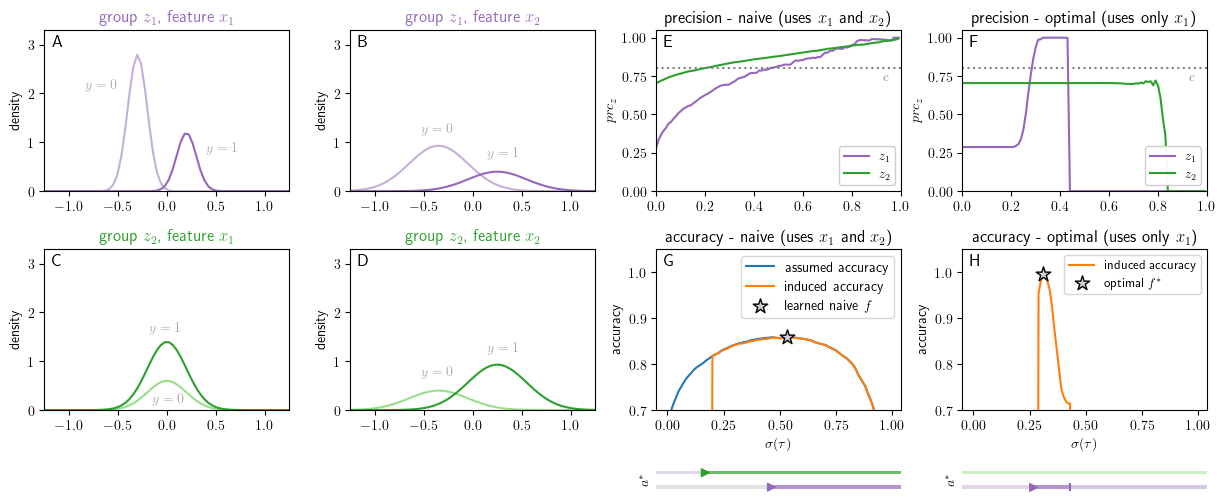

In [158]:
fig = plt.figure() #(constrained_layout=True)
fig.set_size_inches(15,6)
spec = fig.add_gridspec(ncols=4, nrows=3, height_ratios=[1,1,0.15], hspace=0.5, wspace=0.25)

tab20 = plt.get_cmap('tab20')
clrs = [[tab20(15),tab20(14)], [tab20(9),tab20(8)], [tab20(5),tab20(4)], [tab20(19),tab20(18)]]

axs = [[]]*12
x_ = np.linspace(-2,2,n)

def Gaussians(dist):
    y0 = (1-dist.pos_prob) * np.exp(-0.5 * ((x_ - dist.neg_mu) / dist.neg_std)**2) / (dist.neg_std * np.sqrt(2 * np.pi))
    y1 = dist.pos_prob * np.exp(-0.5 * ((x_ - dist.pos_mu) / dist.pos_std)**2) / (dist.pos_std * np.sqrt(2 * np.pi))
    return np.asarray([y0,y1]).T

# densities:
for i,dist in enumerate(dists):
    grp = int(i/2)+1
    feat = i % 2 +1
    axs[i] = fig.add_subplot(spec[grp-1,feat-1])
    y_ = Gaussians(dist)
    axs[i].plot(x_, y_[:,0], c=clrs[grp][0])
    axs[i].plot(x_, y_[:,1], c=clrs[grp][1])
    axs[i].set_title(r'$p(x_{}\mid y,z_{})$'.format(i,grp),color=clrs[grp][1])
    axs[i].set_title(r'group $z_{}$, feature $x_{}$'.format(grp,feat),color=clrs[grp][1])
    axs[i].set_ylabel('density')
    axs[i].set_ylim(0,3.3)
    axs[i].set_xlim(-1.25,1.25)

xs = [[-0.5,0.4], [-0.2,0.15], [0.18,-0.18], [-0.2,0.15]]
ys = [[2.3,1],    [1.4,0.9],   [0.35,1.8],   [0.9,1.4]]
for i in range(4):
    axs[i].text(xs[i][0], ys[i][0], r'$y=0$', ha='right', va='top', color='darkgrey')
    axs[i].text(xs[i][1], ys[i][1], r'$y=1$', ha='left', va='top', color='darkgrey')
    
# precisions:
titles = [r'naive (uses  $x_1$ and $x_2$)', r'optimal (uses only $x_1$)']
naive_prc = [naive_res[f"z{0}_prec"].values, naive_res[f"z{1}_prec"].values]
opt_prc = [opt_res[f"z{0}_prec"].values, opt_res[f"z{1}_prec"].values]
prcs = [naive_prc, opt_prc]
x_ = naive_res["b"].values
k = 4
for i, prc in enumerate(prcs):
    axs[k+i] = fig.add_subplot(spec[0,2+i])
    axs[k+i].plot(x_, prc[0], c=clrs[1][1], label=r'$z_1$')
    axs[k+i].plot(x_, prc[1], c=clrs[2][1], label=r'$z_2$')
    axs[k+i].text(0.95, c_u-0.075, r'$c$', color='grey', ha='right', fontsize=9)
    axs[k+i].axhline(y=c_u, linestyle=':', c='grey')
    axs[k+i].set_title('precision - ' + titles[i])
    axs[k+i].set_ylabel(r'$prc_z$')
#     axs[k+i].set_xlabel(r'$\sigma(\tau)$')
    axs[k+i].set_xlim(0,1)
    axs[k+i].set_ylim(0,1.05)    
    axs[k+i].legend(fontsize=9, framealpha=0.95, loc='lower right')
    

# accuracies:
k = 6
for i, res in enumerate([naive_res, opt_res]):
    axs[k+i] = fig.add_subplot(spec[1,2+i])
    if i==0:
        axs[k+i].plot(x_, res["acc"], c='tab:blue', label="acc")
    axs[k+i].plot(x_, res["induced_acc"], c='tab:orange', label="ind_acc")
    mx = np.max(res["induced_acc"])
    argmx = x_[np.argmax(res["induced_acc"])]
    axs[k+i].scatter(argmx,mx,marker='*',c='lightgrey',edgecolors='k',s=120,zorder=5)
    axs[k+i].set_ylim(0.7,1.05)
    axs[k+i].set_xlabel(r'$\sigma(\tau)$')
    axs[k+i].set_ylabel('accuracy')
    axs[k+i].set_title('accuracy - ' + titles[i])
axs[k].legend(['assumed accuracy', 'induced accuracy', r'learned naive $f$'], fontsize=10)
axs[k+1].legend(['induced accuracy', r'optimal $f^*$'], fontsize=9)
    
    
# applications: 
cutoffs = [[n+10, n+10], [n+10, n+10]]
for j in [0,1]:
    for i in [0,1]:
        idx = np.where(prcs[j][i]>c_u)[0]
        if idx.size > 0:
            cutoffs[j][i] = idx[0]
width = 0.075
delta = 0.3
for i in range(2):
    axs[i+10] = fig.add_subplot(spec[2,i+2])    

cutoff0 = [np.where(prc>c_u)[0][0] for prc in prcs[0]]
axs[10].barh([0,delta], [cutoff0[0],cutoff0[1]], width, color=[clrs[0][0],clrs[1][0]], alpha=0.5)
axs[10].barh([0,delta], [n-cutoff0[0],n-cutoff0[1]], width, left=[cutoff0[0],cutoff0[1]], color=[clrs[1][1],clrs[2][1]], alpha=0.7)
axs[10].scatter([cutoff0[0],cutoff0[1]],[0,delta], marker='>', s=30, c=[clrs[1][1],clrs[2][1]], zorder=3)

cutoff1 = np.where(prcs[1][0]>c_u)[0][0]
noapp1 = np.where(prcs[1][0]==0)[0][0]
axs[11].barh([0,delta], [cutoff1,n], width, color=[clrs[1][0],clrs[2][0]], alpha=0.5)
# axs[11].barh([0,delta], [n-cutoffs[1][0],n-cutoffs[1][1]], width, left=[cutoffs[1][0],cutoffs[1][1]], color=[clrs[1][1],clrs[2][1]], alpha=0.7)
axs[11].barh([0,delta], [noapp1-cutoff1,0], width, left=[cutoff1,0], color=[clrs[1][1],clrs[2][1]], alpha=0.7)
axs[11].barh([0,delta], [n-noapp1,0], width, left=[noapp1,0], color=[clrs[1][0],clrs[2][0]], alpha=0.7)
axs[11].scatter(cutoff1,0, marker='>', s=30, c=clrs[1][1], zorder=3)
axs[11].scatter(noapp1,0, marker='|', s=30, c=clrs[1][1], zorder=3)

for i in [10,11]:
    axs[i].invert_yaxis()
    axs[i].set_xlim(0,n)
    axs[i].set_ylim(-0.1,delta+0.1)
    axs[i].set_ylabel(r'$a^*$')
    axs[i].spines['left'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    axs[i].set_yticks([])
    axs[i].set_xticks([])

    
for i in range(8):
    axs[i].text(.03, .97, chr(ord('A')+i), ha='left', va='top', 
                fontweight='bold', fontsize=12, transform=axs[i].transAxes)

    

    
if SAVE:
    plt.savefig(path + '/ordering.pdf', format='pdf')
    plt.savefig(path + '/ordering.png', format='png')
else:
    plt.show()
